In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
import ProgressMeter

In [2]:
import ReactiveMP.messageout

In [3]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [235]:
function NN(y_,u_,θ)
    W1, b1 = reshape(θ[1:10],(5,2)), θ[11:15]
    W2, b2 = θ[16:20], θ[end]
    x = tanh.(W1*[y_;u_] .+ b1)
    W2'x + b2
end

NN (generic function with 1 method)

In [238]:
NN(1.,2.3,randn(21))

2.2054269196979766

In [334]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [353]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]
    
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    
    
    sigmoid_out = [NN(y_prev[i], u[i], params_f) for i in 1:n]

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2])) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)
    for t in 1:n

        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}

        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta, q = FullFactorisation() }
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + sigmoid_out[t]

        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w) where { q = q(y[t], y_lat3[t])q(w) }
        
        h_prev = h[t]
    end

    # return variables
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [354]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(dim), 0.1*diageye(dim)), w_prior=(1.0, 1e-2), dim=2, vmp_its = 10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, dim, model_flow, params, h_prior, w_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_post = getmarginals(h)
    
    h_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(h_post, (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [355]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [356]:
Random.seed!(42)

n_samples = 1000
controls_ = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                 Dict(:er_var=>1e-2, :u=>controls_))

(Any[0.7067351815667464, 0.08746470704543638, 0.37446122237124385, -0.07565657406900078, -0.0018621178504928894, -0.11427587788072191, 0.7554858002289861, 0.6764032652343485, 0.6669908593766272, -0.7361727244248575  …  -0.7400951924128312, -0.2550558833918564, 0.42826288306946586, 0.04920473022992353, 0.28541791009983697, -0.4443513888352573, -0.013057145372572791, -0.5592175097461611, -0.7155493153428985, 0.7364505850604093], [-0.444383357109696, 0.7094507153676658, 0.05751629800954532, 0.5522473321769763, -0.1901467272418828, -0.04872270606726035, -0.09866153161664788, 0.49128669942130654, 0.776734255380297, 0.7752289799374701  …  -0.8452592795088724, -0.46102976480010915, 0.4995767581131512, 0.021265539340930537, 0.10647453942912108, -0.5609138788144646, 0.17929271107947592, -0.47452214441752905, -0.7796307702427763, 0.7992495200670281], [-0.5560268761463861, 0.0027155338009193846, -0.029948409035891056, 0.17778610980573248, -0.11449015317288201, -0.04686058821676746, 0.015614346264

In [357]:
observations_prev = y_obs[1:end-1]
observations = y_obs[2:end];
controls = controls_[order_u:end];

In [358]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

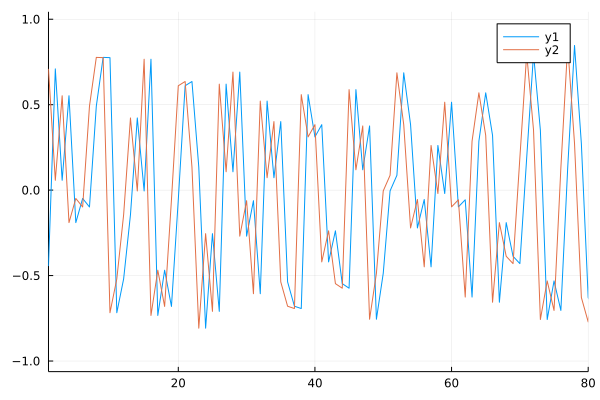

In [359]:
from, to = 1, 80
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to))

In [360]:
function FE(params)
    fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, dim=2, vmp_its=1)
    return fe[end]
end;

In [361]:
param_len = nr_params(model_flow)

12

In [362]:
model_params = randn(param_len+21+2);

In [363]:
fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, dim=2, vmp_its=1);



In [364]:
w

Marginal(GammaShapeRate{Float64}(a=0.6954704008993184, b=0.6265749571022192))

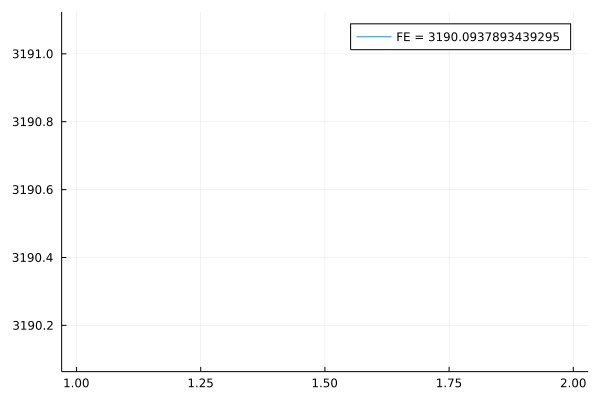

In [365]:
gr()
plot(fe, label="FE = $(fe[end])")

In [410]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)



Iter     Function value   Gradient norm 
     0     3.195172e+03     2.267767e+03
 * time: 0.00012493133544921875
     1     2.712413e+03     1.591499e+03
 * time: 20.148194074630737
     2     1.230365e+02     5.265188e+03
 * time: 28.084846019744873
     3     1.223772e+02     5.291644e+03
 * time: 76.92801690101624
     4     1.221318e+02     5.303346e+03
 * time: 125.74681901931763
     5     1.221318e+02     5.303346e+03
 * time: 165.89196586608887
     6     1.221318e+02     5.303346e+03
 * time: 165.89243698120117


 * Status: success

 * Candidate solution
    Final objective value:     1.221318e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.30e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   166  (vs limit Inf)
    Iterations:    6
    f(x) calls:    200
    ∇f(x) calls:   200


In [411]:
inf_params = Optim.minimizer(res)
FE(inf_params)

88.20406552635905

In [413]:
inf_params = Optim.minimizer(res)


fe, h, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, dim=2, vmp_its=100);

In [415]:
inv(mean(w))

0.01527506118700651

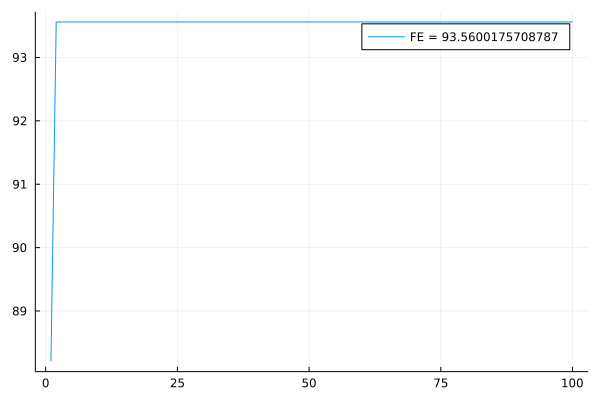

In [414]:
plot(fe[1:end], label="FE = $(fe[end])")

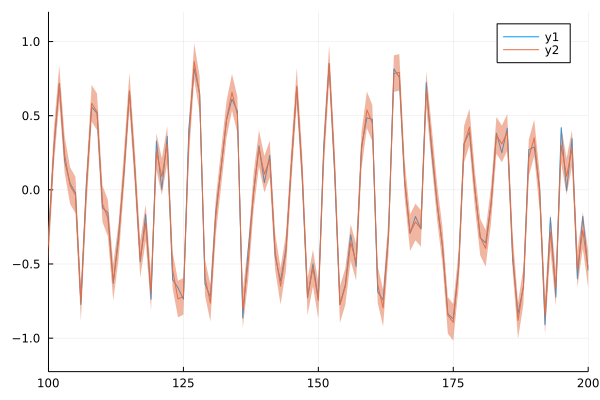

In [420]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(100, 200))
plot!(my, ribbon=sqrt.(vy))

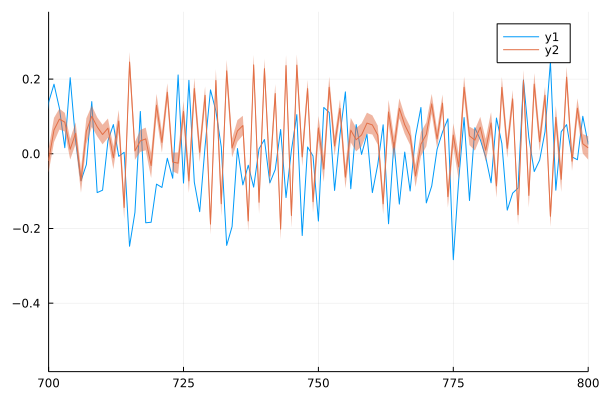

In [421]:
mh, vh = mean.(h), cov.(h)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(700, 800))

In [559]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    θ   = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w   = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    sigmoid_pred = NN(y_prev, u, params_f)

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2])) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())

    # specify observations
    
    ar_node, h ~ AR(h_0, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w) where { q = q(y, y_lat_3)q(w) }
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [560]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(dim), diageye(dim)), w_prior=(1.0, 1.0), dim=2, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(dim, model_flow, params, h_prior, w_prior,
                                                                                              observation_prev, control,
                                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [561]:
(mean(h[end]), precision(h[end]))
(shape(w), rate(w))
inv(mean(w))

0.01527506118700651

In [562]:
mean(h[end])

2-element Vector{Float64}:
 0.015758703922523314
 0.025761436596656057

In [585]:
predictions = []
h_pred = (mean(h[end]), precision(h[end]))
h0_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred_, h0_pred, w_pred_, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, dim=2, vmp_its=1)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred_), precision(h_pred_))
    push!(rw, [mean(h_pred_)[1], cov(h_pred_)[1]])
end

In [580]:
mean.(predictions)[42]

-1.2991122452815196

In [579]:
mx, vx = mean.(predictions), cov.(predictions)

([0.5584841966514861, -0.05074626531845175, -1.9924414720030459, -1.6942004365325467, -0.6521046987402757, 1.0188373336644798, -0.08029599291727647, 0.14996434657991348, -2.0372667726662943, -1.1753617905248543  …  -1.7838705609522936, -1.995964063842106, -0.8532379476687632, 1.0224491182830373, 0.44227583725632824, -0.4212743806646002, -1.7917104458074702, -0.8442370537665754, -1.2145889761117343, -0.4348021763552212], [0.5006610076408905, 0.8066072050121117, 0.8066072050121115, 0.8066072050118139, 0.8066072050118396, 0.806607205011976, 0.8066072050120789, 0.8066072050121073, 0.8066072050121257, 0.8066072050118103  …  0.8066072050119428, 0.8066072050118317, 0.8066072050118139, 0.8066072050119364, 0.8066072050120786, 0.806607205012111, 0.806607205012032, 0.8066072050118311, 0.8066072050119379, 0.8066072050118857])

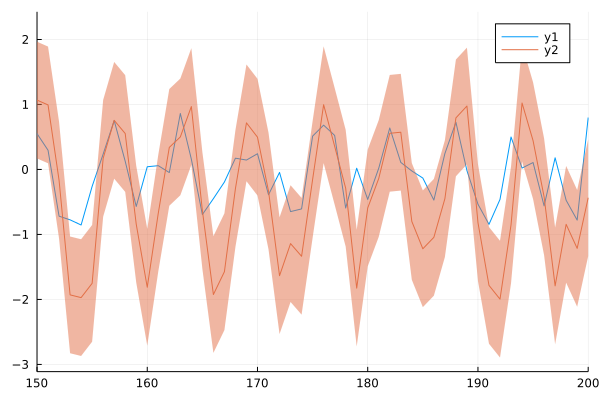

In [589]:
plot(Y_test)
plot!(mx, ribbon=sqrt.(vx), xlims=(150, 200))

In [383]:
n_output = [NN(y_prev, u, inf_params[13:end]) for (y_prev, u) in zip(X_test, U_test)]

200-element Vector{Float64}:
  0.6135179790611298
  0.07626358035812815
 -1.8654316263281923
 -1.5671905908580843
 -0.5250948530648931
  1.145847179341515
  0.04671385275951899
  0.27697419225648656
 -1.9102569269914305
 -1.0483519448499863
 -0.45700217521950853
  0.983316897190388
  0.5648308186224458
  ⋮
  1.102940723535071
 -0.6900089398797878
 -1.656860715277586
 -1.8689542181678305
 -0.7262281019936234
  1.1494589639599961
  0.5692856829335478
 -0.29426453498836735
 -1.6647006001325977
 -0.7172272080913726
 -1.0875791304365772
 -0.30779233067954703

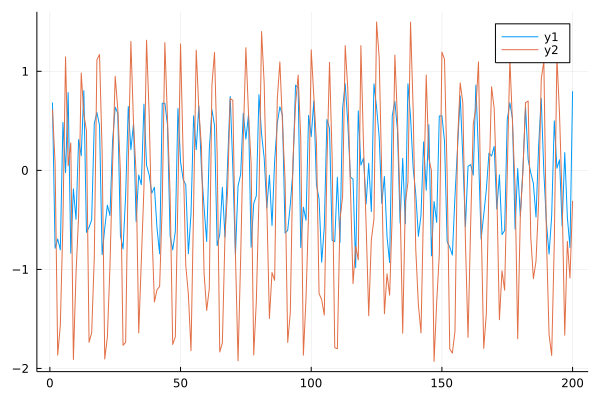

In [384]:
plot(Y_test)
plot!(n_output)

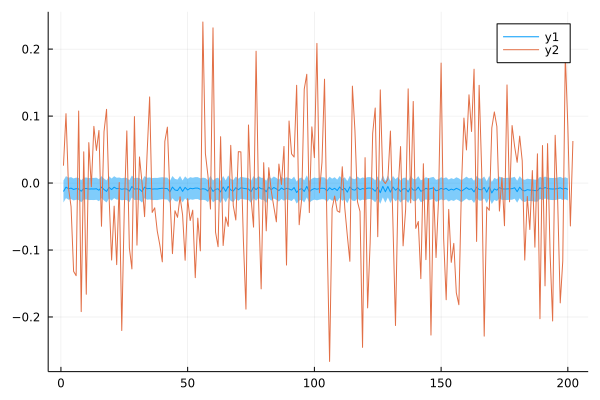

In [270]:
plot(first.(rw), ribbon=sqrt.(last.(rw)))
plot!(h_gen[800:end])
# plot!(mx, ribbon=sqrt.(vx))